<a href="https://colab.research.google.com/github/chenphopp/marketing_segmentation/blob/main/8_Shopping_Kmean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [4]:
# df = pd.read_excel("8_Shopping.xlsx")
url = "https://github.com/chenphopp/marketing_segmentation/raw/main/8_Shopping.xlsx"
df = pd.read_excel(url)
display(df)

,Readymade,Frozenfoods,Alcohol,FreshVegetables,Milk,Bakerygoods,Freshmeat,Toiletries,Snacks,Tinnedgoods,GENDER,Age,MARITAL,CHILDREN,WORKING
0,1,0,0,0,0,0,0,0,1,0,Female,18 to 30,Widowed,No,Yes
1,1,0,0,0,0,0,0,1,0,0,Female,18 to 30,Separated,No,Yes
2,1,0,0,0,0,0,0,1,1,0,Male,18 to 30,Single,No,Yes
3,1,0,0,0,1,1,0,0,0,0,Female,18 to 30,Widowed,No,Yes
4,1,0,0,0,0,0,0,0,0,0,Female,18 to 30,Separated,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,0,0,1,0,0,0,0,0,0,0,Male,18 to 30,Single,No,Yes
782,1,1,0,0,0,1,0,0,1,0,Male,18 to 30,Single,No,Yes
783,0,0,1,0,0,0,0,0,0,0,Male,18 to 30,Single,No,Yes
784,0,1,1,0,0,0,0,0,1,0,Male,18 to 30,Single,No,Yes


In [5]:
# ระบุคอลัมน์ตัวเลข/หมวดหมู่ (ตามตัวอย่างไฟล์ของคุณ)
numeric_cols = ['Readymade','Frozenfoods','Alcohol','FreshVegetables','Milk',
                'Bakerygoods','Freshmeat','Toiletries','Snacks','Tinnedgoods']
categorical_cols = ['GENDER','Age','MARITAL','CHILDREN','WORKING']

In [6]:
# สร้าง preprocessor: scale ตัวเลข + one-hot หมวดหมู่
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_cols),
    #("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_cols)
])

In [7]:
def cluster_profile(data_with_labels, label_col="Cluster", top_cat=5):
    out = {}
    for c in sorted(data_with_labels[label_col].unique()):
        sub = data_with_labels[data_with_labels[label_col]==c]
        # ตัวเลข: ค่าเฉลี่ย
        num_mean = sub[numeric_cols].mean().sort_values(ascending=False)
        # หมวดหมู่: นับสัดส่วน (เฉพาะ top_cat)
        cat_props = {}
        for col in categorical_cols:
            props = (sub[col].value_counts(normalize=True)
                     .head(top_cat).map(lambda v: f"{v:.1%}").to_dict())
            cat_props[col] = props
        out[c] = {"n": len(sub), "num_mean": num_mean.to_dict(), "cat_props": cat_props}
    return out

In [8]:
X = preprocessor.fit_transform(df)
print(X)

[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]]


In [9]:
# เอาชื่อฟีเจอร์มาใช้ตั้งคอลัมน์
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = np.r_[numeric_cols, cat_feature_names]

# แปลงเป็น DataFrame โดยตรงc
X_df = pd.DataFrame(X, columns=feature_names, index=df.index)

print(X_df.shape)
X_df.head()

(786, 26)


,Readymade,Frozenfoods,Alcohol,FreshVegetables,Milk,Bakerygoods,Freshmeat,Toiletries,Snacks,Tinnedgoods,...,Age_Over 60,MARITAL_Divorced,MARITAL_Married,MARITAL_Separated,MARITAL_Single,MARITAL_Widowed,CHILDREN_No,CHILDREN_Yes,WORKING_No,WORKING_Yes
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [10]:
# ลูปลอง k เพื่อดู inertia (elbow) และ silhouette
ks = range(2, 15)
inertias, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

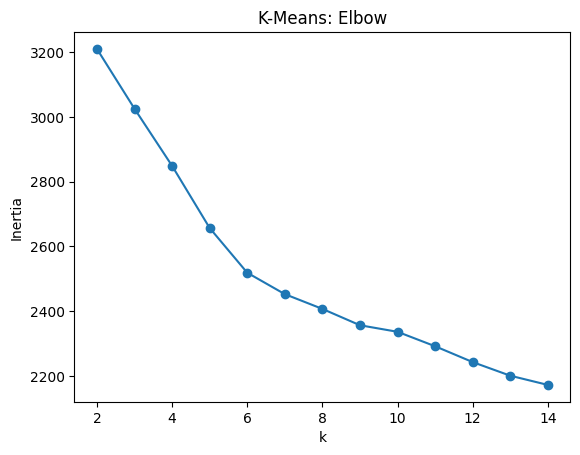

In [11]:
# กราฟ elbow
plt.figure()
plt.plot(list(ks), inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("K-Means: Elbow")
plt.show()


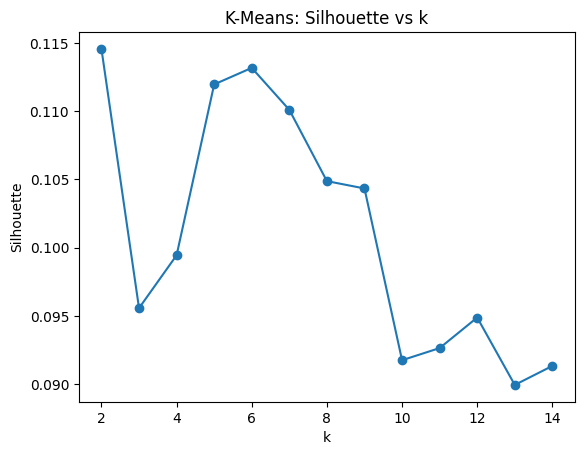

In [12]:
# กราฟ silhouette
plt.figure()
plt.plot(list(ks), sils, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("K-Means: Silhouette vs k")
plt.show()

In [13]:
# เลือก k ที่ต้องการ
best_k = 6
kmeans_pipe = Pipeline([("prep", preprocessor),
                        ("cluster", KMeans(n_clusters=best_k, random_state=42))])
labels_km = kmeans_pipe.fit_predict(df)
#print(labels_km)

In [14]:
#เพิ่ม label กลับเข้า DataFrame เพื่อวิเคราะห์
df_km = df.copy()
df_km["Cluster"] = labels_km
print("Silhouette (k-means):", silhouette_score(preprocessor.transform(df), labels_km))
df_km.head()

Silhouette (k-means): 0.11317921779270068


,Readymade,Frozenfoods,Alcohol,FreshVegetables,Milk,Bakerygoods,Freshmeat,Toiletries,Snacks,Tinnedgoods,GENDER,Age,MARITAL,CHILDREN,WORKING,Cluster
0,1,0,0,0,0,0,0,0,1,0,Female,18 to 30,Widowed,No,Yes,4
1,1,0,0,0,0,0,0,1,0,0,Female,18 to 30,Separated,No,Yes,4
2,1,0,0,0,0,0,0,1,1,0,Male,18 to 30,Single,No,Yes,1
3,1,0,0,0,1,1,0,0,0,0,Female,18 to 30,Widowed,No,Yes,4
4,1,0,0,0,0,0,0,0,0,0,Female,18 to 30,Separated,No,Yes,4


In [15]:
#สรุปจำนวนสมาชิกแต่ละคลัสเตอร์
print(df_km["Cluster"].value_counts())

Cluster
4    177
0    167
2    138
3    109
1     99
5     96
Name: count, dtype: int64


In [16]:
profile_km = cluster_profile(df_km, "Cluster", top_cat=5)

In [17]:
for c, stats in profile_km.items():
    print(f"\n=== Cluster {c} (n={stats['n']}) ===")

    # ตัวเลข: แสดงเฉลี่ย top 10 ตัวแรก (ตัดให้สั้น)
    num_mean = stats["num_mean"]
    for feat, val in list(num_mean.items())[:10]:
        print(f"- {feat}: {val:.3f}")

    # หมวดหมู่: สัดส่วน
    print("Categoricals:")
    for col, props in stats["cat_props"].items():
        pairs = [f"{k}: {v}" for k, v in props.items()]
        print(f"  • {col} -> " + "; ".join(pairs))


=== Cluster 0 (n=167) ===
- Snacks: 0.557
- Bakerygoods: 0.521
- Tinnedgoods: 0.473
- Readymade: 0.275
- Frozenfoods: 0.251
- Alcohol: 0.168
- Milk: 0.138
- FreshVegetables: 0.090
- Toiletries: 0.090
- Freshmeat: 0.018
Categoricals:
  • GENDER -> Female: 100.0%
  • Age -> 31 to 40: 40.7%; 18 to 30: 30.5%; 51 to 60: 12.0%; 41 to 50: 9.0%; Over 60: 7.8%
  • MARITAL -> Married: 38.9%; Single: 21.0%; Separated: 19.2%; Widowed: 15.0%; Divorced: 6.0%
  • CHILDREN -> Yes: 100.0%
  • WORKING -> Yes: 81.4%; No: 18.6%

=== Cluster 1 (n=99) ===
- Readymade: 0.515
- Frozenfoods: 0.515
- Alcohol: 0.515
- Snacks: 0.394
- Bakerygoods: 0.293
- Tinnedgoods: 0.162
- Milk: 0.091
- FreshVegetables: 0.040
- Toiletries: 0.040
- Freshmeat: 0.000
Categoricals:
  • GENDER -> Male: 88.9%; Female: 11.1%
  • Age -> 18 to 30: 99.0%; Over 60: 1.0%
  • MARITAL -> Single: 97.0%; Widowed: 2.0%; Separated: 1.0%
  • CHILDREN -> No: 94.9%; Yes: 5.1%
  • WORKING -> Yes: 53.5%; No: 46.5%

=== Cluster 2 (n=138) ===
- Ready

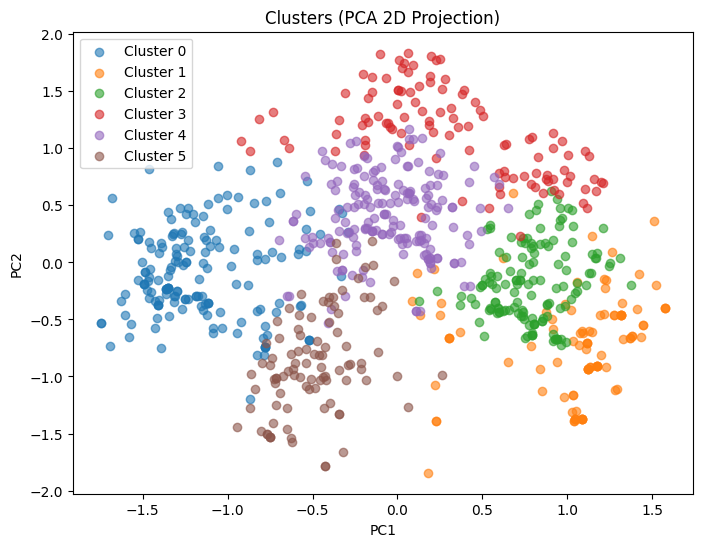

In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(preprocessor.transform(df))

# สร้าง DataFrame สำหรับ plot
plot_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
plot_df["Cluster"] = labels_km

# Plot scatter
plt.figure(figsize=(8,6))
for c in sorted(plot_df["Cluster"].unique()):
    subset = plot_df[plot_df["Cluster"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.6)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters (PCA 2D Projection)")
plt.legend()
plt.show()

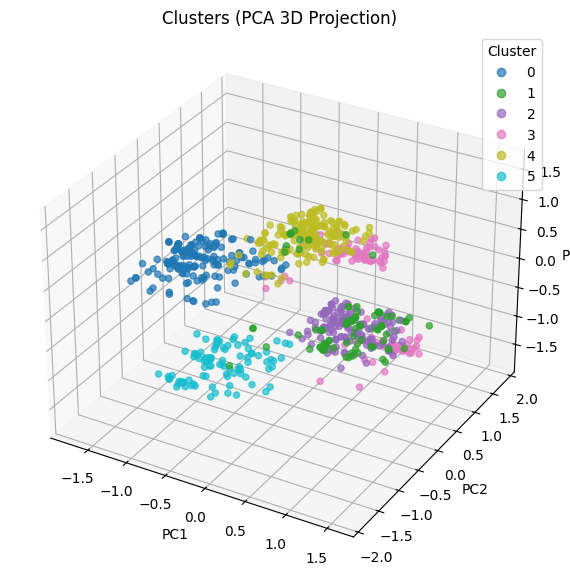

In [19]:
pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(preprocessor.transform(df))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
                     c=labels_km, cmap="tab10", alpha=0.7)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Clusters (PCA 3D Projection)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()
